<a href="https://colab.research.google.com/github/esraasiyamek/buildnow_AI_Task/blob/main/categorize_items.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setup and Installation

In [1]:
!pip install openai pandas numpy matplotlib seaborn scikit-learn python-dotenv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import re
import openai
import os
from dotenv import load_dotenv
import warnings
from openai import OpenAI

# Configure warnings and OpenAI
warnings.filterwarnings('ignore')
load_dotenv()

# Initialize OpenAI client (Please provide OpenAI API Key)
OPENAI_API_KEY = "" #@param {type:"string"}
client = OpenAI(api_key=OPENAI_API_KEY)


2. Data Loading and Initial Exploration


In [4]:
# Load the dataset (Please upload the dataset file "prupurchase-order-items.xlsx" in this step)
from google.colab import files
uploaded = files.upload()

# Read the Excel file
df = pd.read_excel('purchase-order-items.xlsx')

# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

print("\nColumn info:")
print(df.info())

print("\nSample item names:")
print(df['Item Name'].sample(10).values)

Saving purchase-order-items.xlsx to purchase-order-items.xlsx
Dataset shape: (3150, 11)

First few rows:


,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID,Project ID
0,3263831000000089042,NaN,75.21,227510.25,227510.25,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
1,3263831000000089046,NaN,15.00,47250.00,47250.00,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
2,3263831000000089044,NaN,50.00,160000.00,160000.00,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
3,3263831000000092044,NaN,12.00,38280.00,38280.00,3263831000000092040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
4,3263831000000092052,NaN,2.00,5900.00,5900.00,3263831000000092040,NaN,SAR,3263831000000034003,3.263831e+18,NaN



Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item ID            3150 non-null   int64  
 1   Item Name          2910 non-null   object 
 2   Quantity           3150 non-null   float64
 3   Total Bcy          3150 non-null   float64
 4   Sub Total Bcy      3150 non-null   float64
 5   Purchase Order ID  3150 non-null   int64  
 6   Product ID         2910 non-null   float64
 7   Currency Code      3150 non-null   object 
 8   Account ID         3150 non-null   int64  
 9   Tax ID             3085 non-null   float64
 10  Project ID         0 non-null      float64
dtypes: float64(6), int64(3), object(2)
memory usage: 270.8+ KB
None

Sample item names:
['O RING SEAL (Configuration:NUTRING SEAL Size:NONE Color:MX91 5829 Style:FUSO)'
 'حديد سابك 14 ملم 12 م'
 '14.0 mm Black Deformed Straight Bar G60 - 12 M - Ittifaq'


3. Data Cleaning and Preprocessing


In [5]:
def clean_text(text):
    """
    Clean and preprocess text by:
    1. Removing special characters and numbers
    2. Standardizing units and measurements
    3. Removing extra whitespace
    4. Handling multilingual text
    """
    if not isinstance(text, str):
        return ""

    # Remove numbers and special characters (except spaces and basic punctuation)
    text = re.sub(r'[^a-zA-Z\u0600-\u06FF\s\.\,\-\/]', ' ', text)

    # Remove common measurement patterns (like 10x20mm, 1.5x6m, etc.)
    text = re.sub(r'\b\d+\.?\d*\s*[xX×]\s*\d+\.?\d*\s*[a-zA-Z]+\b', ' ', text)
    text = re.sub(r'\b\d+\.?\d*\s*[a-zA-Z]+\b', ' ', text)  # Single measurements

    # Remove standalone numbers
    text = re.sub(r'\b\d+\b', ' ', text)

    # Standardize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text.lower()

# Apply cleaning to item names
df['cleaned_name'] = df['Item Name'].apply(clean_text)

# Remove empty or very short descriptions
df = df[df['cleaned_name'].str.len() > 3].copy()

print("\nSample cleaned item names:")
print(df['cleaned_name'].sample(10).values)


Sample cleaned item names:
['سير مروح رقم' 'i/riser deg. hdg osf c/tray w x h x . mm thick'
 'equal tee ppr - tahweel / mm' 'paster server' 'ماسورة حدید بوصة مم م'
 'حديد تسليح سعودي سابك مم م'
 'i/riser deg. cover hdg osf c/tray w x . mm thick'
 'steel checkerd plate . mm' 'ppr pipe pn sdr . mm'
 'reinforcing steel bar ittfaq mm mtr unit ton']


4. Language Translation (Arabic to English)


In [11]:
from tqdm import tqdm

def translate_with_openai(text, target_language="English", pbar=None):
    """
    Translate text using OpenAI's chat model with progress tracking
    """
    if not isinstance(text, str) or not text.strip():
        if pbar:
            pbar.update(1)
        return text

    # Check if text contains Arabic characters
    if not re.search('[\u0600-\u06FF]', text):
        if pbar:
            pbar.update(1)
        return text

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": f"You are a professional translator. Translate to {target_language} preserving technical terms. Only return the translation."},
                {"role": "user", "content": text}
            ],
            temperature=0.1
        )
        result = response.choices[0].message.content.strip()
        if pbar:
            pbar.update(1)
        return result
    except Exception as e:
        if pbar:
            pbar.update(1)
        print(f"\nTranslation failed for text: {text[:50]}... Error: {str(e)[:100]}")
        return text

# Apply translation with progress bar
print("Translating Arabic text to English using OpenAI...")

# Initialize progress bar
with tqdm(total=len(df), desc="Translating") as pbar:
    df['translated_name'] = df['cleaned_name'].apply(
        lambda x: translate_with_openai(x, pbar=pbar))

    # Refresh to ensure progress bar completes
    pbar.refresh()

# Calculate translation stats
total_texts = len(df)
translated = sum(df['cleaned_name'] != df['translated_name'])
print(f"\nTranslation complete! {translated}/{total_texts} items needed translation")

# Sample translations
print("\nSample translations:")
sample_translations = df[df['cleaned_name'] != df['translated_name']].sample(3)
for _, row in sample_translations.iterrows():
    print(f"Original: {row['cleaned_name']}")
    print(f"Translated: {row['translated_name']}\n")
    print("-" * 50)

Translating Arabic text to English using OpenAI...


Translating: 100%|██████████| 2881/2881 [10:33<00:00,  4.55it/s]


Translation complete! 1207/2881 items needed translation

Sample translations:
Original: ماسورة كلاس منار
Translated: Class Manar pipe

--------------------------------------------------
Original: ماسورة حديد مقاس بوصة سماكة . مم طول م
Translated: Iron pipe with a diameter of inches, thickness of mm, and length m.

--------------------------------------------------
Original: حديد وطني مم متر
Translated: National iron mm meter

--------------------------------------------------


5. Text Embedding


In [12]:
def get_openai_embedding(text, model="text-embedding-3-large"):
    """
    Get text embedding using OpenAI's embedding model
    """
    text = text.replace("\n", " ")
    try:
        response = client.embeddings.create(input=[text], model=model)
        return response.data[0].embedding
    except Exception as e:
        print(f"Error getting embedding for text: {text}. Error: {e}")
        return None

# Get embeddings for a sample first to test
print("Getting embeddings for sample items...")
sample_texts = df['translated_name'].sample(5).tolist()
sample_embeddings = [get_openai_embedding(text) for text in sample_texts]

# Get embeddings for all items (this will take time and use API credits)
print("\nGetting embeddings for all items...")
df['embedding'] = df['translated_name'].apply(get_openai_embedding)

# Remove rows where embedding failed
df = df[df['embedding'].notna()].copy()
embeddings = np.array(df['embedding'].tolist())

print(f"\nFinal dataset shape with embeddings: {df.shape}")
print(f"Embedding dimension: {len(embeddings[0])}")

Getting embeddings for sample items...

Getting embeddings for all items...

Final dataset shape with embeddings: (2881, 14)
Embedding dimension: 3072


6. Clustering with K-Means


Visualizing clusters with t-SNE...


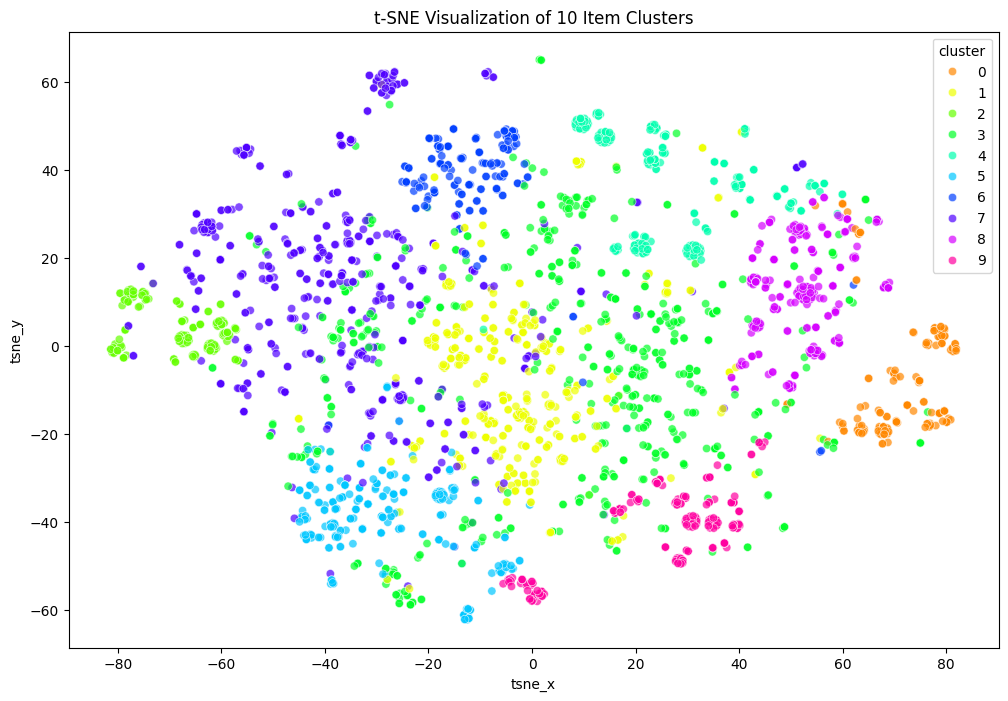

In [14]:
# Set the number of clusters
NUM_CLUSTERS = 10  # It can be adjusted for better resluts

# Perform K-means clustering
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(embeddings)

# Visualize clusters using t-SNE
print("Visualizing clusters with t-SNE...")
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

df['tsne_x'] = embeddings_2d[:, 0]
df['tsne_y'] = embeddings_2d[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_x', y='tsne_y',
    hue='cluster',
    palette=sns.color_palette("hsv", NUM_CLUSTERS),
    data=df,
    legend="full",
    alpha=0.7
)
plt.title(f't-SNE Visualization of {NUM_CLUSTERS} Item Clusters')
plt.show()

7. Labeling Clusters  with LLM


In [16]:
def generate_cluster_labels(cluster_samples, cluster_id):
    """
    Generate descriptive labels for clusters using OpenAI's GPT
    """
    # The prompt can be adjusted for better labeling
    prompt = f"""
        I have clustered purchase order items of construction materials. Here are some sample items from one cluster:/n
        {cluster_samples}

        /n Please suggest a concise specific category name (2-3 words) that best describes this group of construction materials items. DO NOT USE BROAD CATEGORIES NAMES SUCH AS "CONSTRUCTION MATERIALS" OR ANYTHING SIMILAR!
        Respond only with the category name, nothing else.
        """

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that helps categorize products."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error generating label for cluster {cluster_id}: {e}")
        return f"Cluster_{cluster_id}"

# Generate labels for each cluster
cluster_labels = {}
for cluster_id in range(NUM_CLUSTERS):
    # Get sample items from the cluster
    samples = df[df['cluster'] == cluster_id]['translated_name'].sample(min(10, len(df[df['cluster'] == cluster_id]))).tolist()
    samples_str = "\n".join([f"- {sample}" for sample in samples])

    print(f"\nGenerating label for cluster {cluster_id} with samples:")
    print(samples_str)

    label = generate_cluster_labels(samples_str, cluster_id)
    cluster_labels[cluster_id] = label
    print(f"Generated label: {label}")

# Add cluster labels to dataframe
df['category'] = df['cluster'].map(cluster_labels)

print("\nFinal cluster labels:")
print(cluster_labels)


Generating label for cluster 0 with samples:
- Domestic reinforced steel, diameter 12 mm.
- Reinforcement steel agreement, millimeter.
- Reinforcing steel agreement document
- Dove-tailed reinforcement steel.
- Reinforcing steel contract document
- Reinforcement steel agreement of 1 meter.
- Reinforcement steel of 1 millimeter
- Reinforcement steel agreement of 1 mm.
- Reinforcing steel agreement document
- Domestic reinforced steel bar, diameter in millimeters
Generated label: Reinforcement Steel Products

Generating label for cluster 1 with samples:
- swedish wood in . mtr - full thickness
- hdg osf c/tray w x h x . mm thick x mm length
- dry wall screw mm x
- hdg transformer rail qu - wt . kg/m - lenght . m
- hdg angel x x mm, m
- steel checkerd plate . mm
- hr coil cheqc . x mm
- ipe . . mm mtr unit pcs
- checkered plate . x x mm
- cable mm x c
Generated label: Building Supplies

Generating label for cluster 2 with samples:
- xt h tmd - p f f
- xt n ekip dip ls/i in p f f
- xt n t

8. Analysis and Visualization


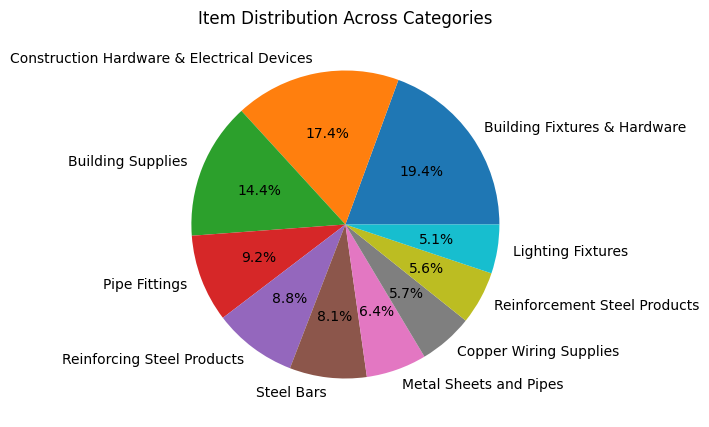

In [17]:
# Item Distribution Across Categories With a Pie Chart
plt.figure(figsize=(10,5))
df['category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.title('Item Distribution Across Categories')
plt.show()

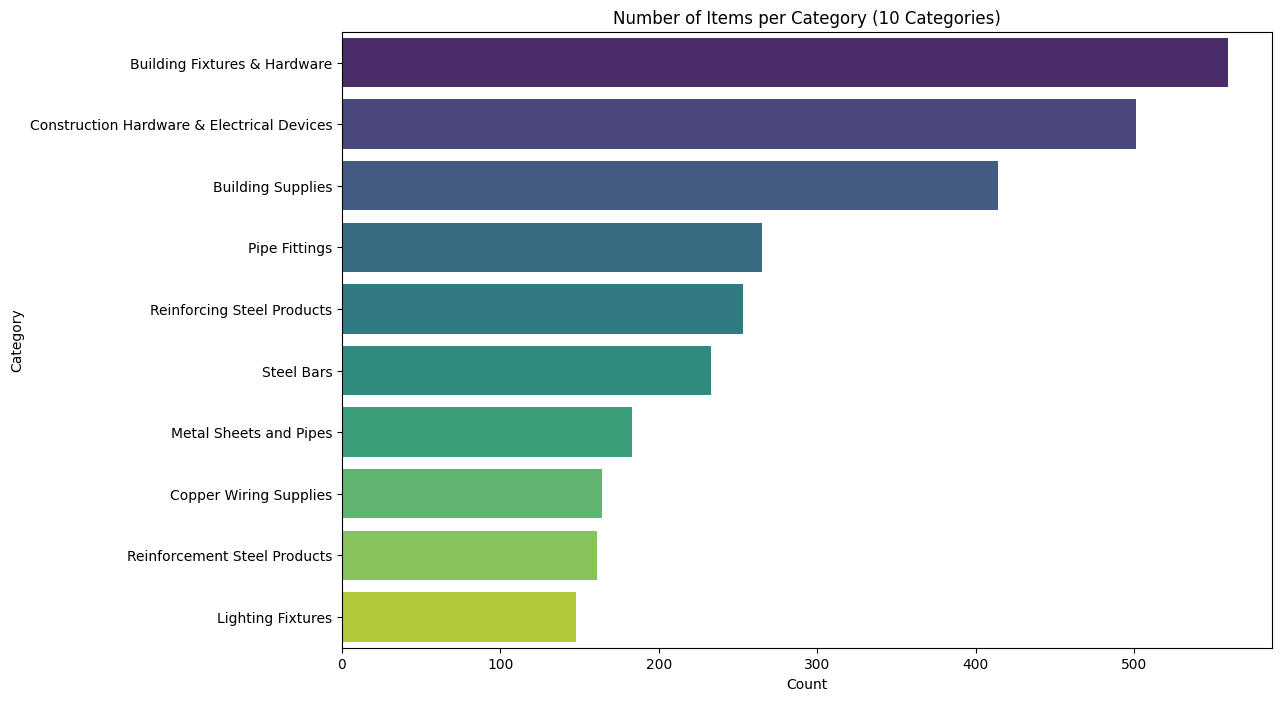

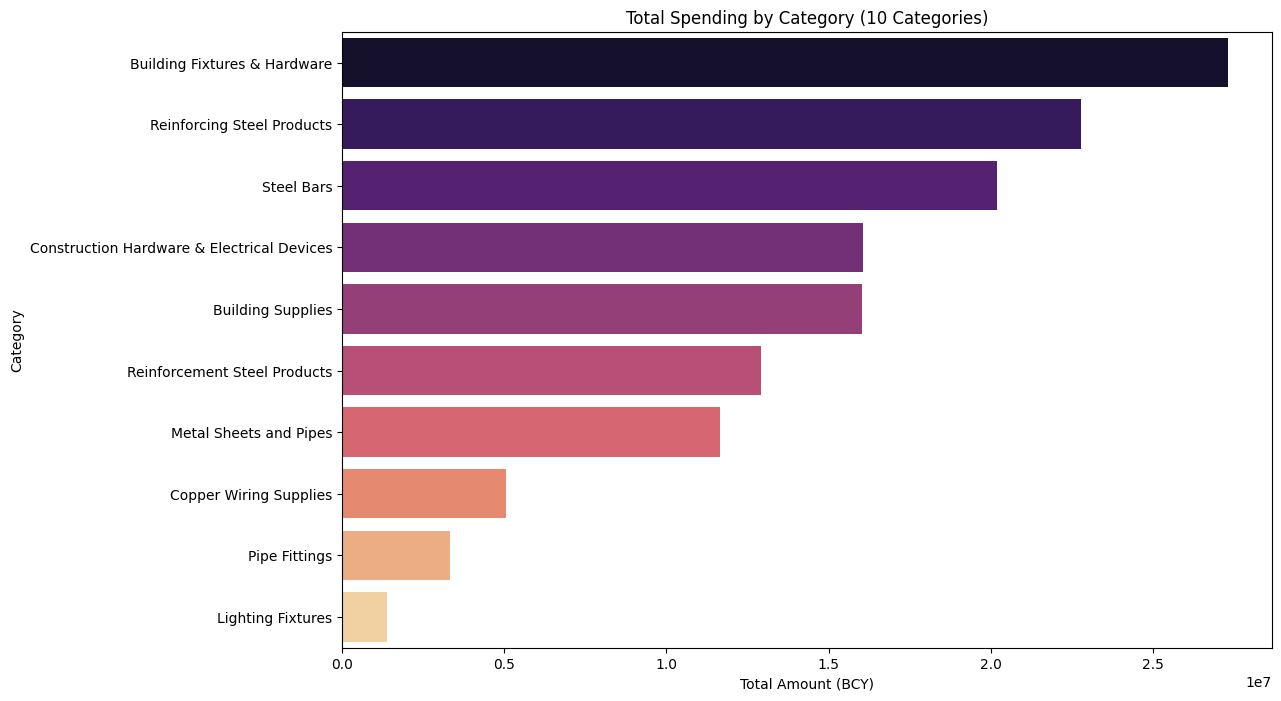


Category Statistics:


,item_count,total_spending,avg_spending_per_item,cluster_id
category,,,,
Building Fixtures & Hardware,559,27295818.98,48829.729839,3
Reinforcing Steel Products,253,22773095.93,90012.236877,8
Steel Bars,233,20187483.63,86641.560644,4
Construction Hardware & Electrical Devices,501,16072951.49,32081.739501,7
Building Supplies,414,16028852.42,38717.034831,1
Reinforcement Steel Products,161,12901802.96,80135.422112,0
Metal Sheets and Pipes,183,11653662.39,63681.215246,9
Copper Wiring Supplies,164,5045407.14,30764.677683,6
Pipe Fittings,265,3325469.88,12548.942943,5



Top Items by Spending:


,Item Name,category,Total Bcy
1290,حديد كويل 9 مل,Metal Sheets and Pipes,1519000.00
2718,Crump Rubber,Building Fixtures & Hardware,1306100.00
1347,خرسانة جاهزة,Building Fixtures & Hardware,1150000.00
1500,Ajeej Steel 14 mm - Shadeed,Building Supplies,1076100.00
1256,حديد كويل 9 مل,Metal Sheets and Pipes,980000.00
1289,حديد كويل 11 مل,Metal Sheets and Pipes,980000.00
1520,m 9 coil - حديد كويل 9 ملم املس,Building Fixtures & Hardware,955200.00
2821,60 kVA / 48 kW 3 Battery Backup Uninterruptibl...,Construction Hardware & Electrical Devices,951300.00
1658,حديد كويل 11 مل,Metal Sheets and Pipes,940800.00
2545,Ovation Rêve E-3 IP Includes: Light Engine Onl...,Construction Hardware & Electrical Devices,938869.21


In [21]:
# Category distribution
category_dist = df['category'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=category_dist.values, y=category_dist.index, palette="viridis")
plt.title(f'Number of Items per Category ({NUM_CLUSTERS} Categories)')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# Spending by category
spending_by_category = df.groupby('category')['Total Bcy'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=spending_by_category.values, y=spending_by_category.index, palette="magma")
plt.title(f'Total Spending by Category ({NUM_CLUSTERS} Categories)')
plt.xlabel('Total Amount (BCY)')
plt.ylabel('Category')
plt.show()

# Combined analysis
category_stats = df.groupby('category').agg(
    item_count=('Item ID', 'count'),
    total_spending=('Total Bcy', 'sum'),
    avg_spending_per_item=('Total Bcy', 'mean'),
    cluster_id=('cluster', 'first')
).sort_values('total_spending', ascending=False)

print("\nCategory Statistics:")
display(category_stats)

# Top items by spending
top_items = df.sort_values('Total Bcy', ascending=False).head(20)[['Item Name', 'category', 'Total Bcy']]
print("\nTop Items by Spending:")
display(top_items)

9. Final Insights and Recommendations


In [22]:
print("""
Key Insights and Recommendations:

1. Category Distribution:
- The most common categories are {most_common_cat} with {most_common_count} items.
- The least common categories are {least_common_cat} with only {least_common_count} items each.

2. Spending Patterns:
- The highest spending is in {highest_spending_cat} category with {highest_spending_amount} BCY.
- The category with highest average spending per item is {highest_avg_cat} at {highest_avg_amount} BCY per item.

3. Recommendations:
- Focus credit offerings on {top_3_cats} which account for {percentage}% of total spending.
- Investigate the {low_count_high_spend} category which has few items but significant spending.
- Consider standardizing descriptions for {most_diverse_cat} to improve categorization.

4. Future Improvements:
- Expand the taxonomy with sub-categories for more granular analysis.
- Implement real-time categorization for new purchase orders.
- Add supplier information to analyze category-supplier relationships.
""".format(
    most_common_cat=category_dist.index[0],
    most_common_count=category_dist.values[0],
    least_common_cat=", ".join(category_dist.index[-3:]),
    least_common_count=category_dist.values[-1],
    highest_spending_cat=spending_by_category.index[0],
    highest_spending_amount=spending_by_category.values[0],
    highest_avg_cat=category_stats.sort_values('avg_spending_per_item', ascending=False).index[0],
    highest_avg_amount=category_stats['avg_spending_per_item'].max(),
    top_3_cats=", ".join(spending_by_category.index[:3]),
    percentage=round(spending_by_category[:3].sum() / spending_by_category.sum() * 100, 1),
    low_count_high_spend=category_stats[category_stats['item_count'] < category_stats['item_count'].median()].sort_values('total_spending', ascending=False).index[0],
    most_diverse_cat=df.groupby('category')['translated_name'].nunique().sort_values(ascending=False).index[0]
))


Key Insights and Recommendations:

1. Category Distribution:
- The most common categories are Building Fixtures & Hardware with 559 items.
- The least common categories are Copper Wiring Supplies, Reinforcement Steel Products, Lighting Fixtures with only 148 items each.

2. Spending Patterns:
- The highest spending is in Building Fixtures & Hardware category with 27295818.98 BCY.
- The category with highest average spending per item is Reinforcing Steel Products at 90012.23687747035 BCY per item.

3. Recommendations:
- Focus credit offerings on Building Fixtures & Hardware, Reinforcing Steel Products, Steel Bars which account for 51.4% of total spending.
- Investigate the Steel Bars category which has few items but significant spending.
- Consider standardizing descriptions for Building Fixtures & Hardware to improve categorization.

4. Future Improvements:
- Expand the taxonomy with sub-categories for more granular analysis.
- Implement real-time categorization for new purchase order

10. Exporting Results


In [25]:
# Save results to CSV
ESSENTIAL_COLUMNS = [
    'Item ID',
    'Item Name',          # Original messy name
    'cleaned_name',       # Preprocessed text
    'translated_name',    # Translated to English
    'cluster',            # Cluster ID
    'category',           # LLM-generated category name
    'Total Bcy'           # Financial information
]

df[ESSENTIAL_COLUMNS].to_csv('categorized_purchase_orders.csv', encoding='utf-8-sig', index=False)

files.download('categorized_purchase_orders.csv')



Results exported to CSV files.


In [26]:
# Save Category Statistics

category_stats.to_csv('category_statistics.csv')
files.download('category_statistics.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>